In [1]:
import numpy as np
import random
import geopandas as gpd
import contextily as ctx
import osmnx as ox
import h3
import pandas as pd
#import geodatasets
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon, Point, mapping, MultiPolygon
from shapely.strtree import STRtree
from math import pi, cos, sin, exp, sqrt
from geopy.distance import geodesic

# **GET POIs**

In [2]:
def get_poi_coords(place_name, tags, epsg_code):
    gdf = ox.features_from_place(place_name, tags)

    # Convert to centroid points (geometries → point)
    gdf_points = gdf.copy()
    gdf_points["geometry"] = gdf_points["geometry"].centroid

    # Optional: Get lat/lng
    gdf_latlon = gdf_points.to_crs(epsg=epsg_code)
    gdf_latlon["lat"] = gdf_latlon.geometry.y
    gdf_latlon["lon"] = gdf_latlon.geometry.x
    
    return gdf_latlon[['geometry', 'building', 'name', 'addr:city',
                      'addr:housenumber', 'addr:postcode', 'addr:state',
                      'addr:street', 'building:levels', 'building:use',
                      'lat', 'lon']]

In [3]:
def plot_poi(gdf_poi, epsg_code=3857):
    # Project for basemap and plot
    gdf_points = gdf_poi.copy()
    gdf_points = gdf_points.to_crs(epsg=epsg_code)

    fig, ax = plt.subplots(figsize=(5, 5))
    gdf_points.plot(ax=ax, color="red", markersize=10)

    # Add background basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    ax.axis("off")
    plt.tight_layout()
    plt.show()

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_40648/2707898495.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_points["geometry"] = gdf_points["geometry"].centroid


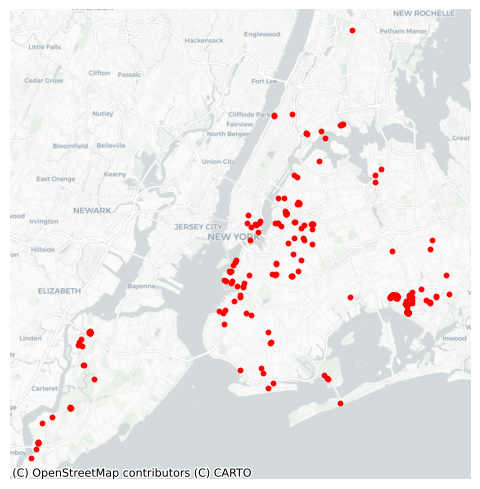

In [4]:
place_name = "New York City, New York, USA"
# tags = {"building": "warehouse", "landuse": "industrial"}
tags = {
    "building": [
        "warehouse",
        "storage_tank",
        "storage",
        "depot",
        "hangar"
    ]
}
epsg_code = 4326

gdf_warehouse = get_poi_coords(place_name, tags, epsg_code)

plot_poi(gdf_warehouse)

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_40648/2707898495.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_points["geometry"] = gdf_points["geometry"].centroid


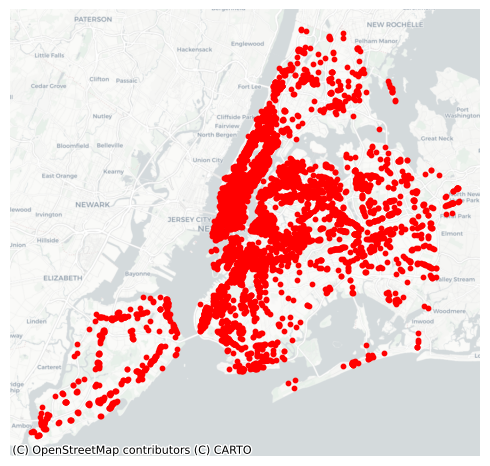

In [5]:
place_name = "New York City, New York, USA"
tags = {"amenity": "restaurant"}
epsg_code = 4326

gdf_restaurant = get_poi_coords(place_name, tags, epsg_code)

plot_poi(gdf_restaurant)

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_40648/2707898495.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_points["geometry"] = gdf_points["geometry"].centroid


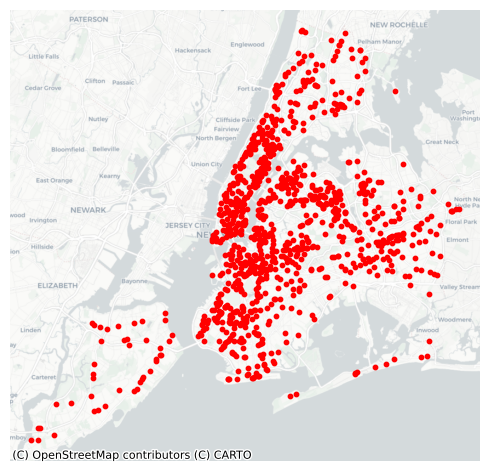

In [6]:
place_name = "New York City, New York, USA"
tags = {"shop": ["supermarket", "grocery"]}
epsg_code = 4326

gdf_grocery = get_poi_coords(place_name, tags, epsg_code)

plot_poi(gdf_grocery)

In [7]:
gdf_warehouse.head()

geometry      building name addr:city  \
element  id                                                                   
relation 3778810     POINT (-73.7998 40.66096)        hangar  DAL       NaN   
way      157929440  POINT (-73.80237 40.64567)  storage_tank  NaN       NaN   
         157929443   POINT (-73.8012 40.64479)  storage_tank  NaN       NaN   
         157929446  POINT (-73.80172 40.64573)  storage_tank  NaN       NaN   
         157929450  POINT (-73.80232 40.64548)  storage_tank  NaN       NaN   

                   addr:housenumber addr:postcode addr:state addr:street  \
element  id                                                                
relation 3778810                NaN           NaN        NaN         NaN   
way      157929440              NaN           NaN        NaN         NaN   
         157929443              NaN           NaN        NaN         NaN   
         157929446              NaN           NaN        NaN         NaN   
         157929450              NaN           NaN        NaN         NaN   

                   building:levels building:use        lat        lon  
element  id                                                            
relation 3778810               NaN          NaN  40.660959 -73.799798  
way      157929440             NaN          NaN  40.645673 -73.802372  
         157929443             NaN          NaN  40.644789 -73.801196  
         157929446             NaN          NaN  40.645730 -73.801721  
         157929450             NaN          NaN  40.645481 -73.802323

In [8]:
def gdf_to_df(gdf, typ):
    # Create DataFrame directly from geometry coordinates and add the type column
    return pd.DataFrame({
        'type': typ,
        'lat': gdf.geometry.y,
        'lon': gdf.geometry.x
    })

# Convert each gdf
df_warehouse = gdf_to_df(gdf_warehouse, 'warehouse')
df_restaurant = gdf_to_df(gdf_restaurant, 'restaurant')
df_grocery = gdf_to_df(gdf_grocery, 'grocery')

# Combine all
poi_df = pd.concat([df_warehouse, df_restaurant, df_grocery], ignore_index=True)

poi_df.tail()


,type,lat,lon
8942,grocery,40.787478,-73.944369
8943,grocery,40.580073,-74.166639
8944,grocery,40.626805,-73.977110
8945,grocery,40.558996,-73.919957
8946,grocery,40.666045,-73.924558


In [9]:
len(gdf_warehouse), len(gdf_restaurant), len(gdf_grocery), len(poi_df)

(277, 7593, 1077, 8947)

# **DEFINE HEX GRID**

In [10]:
# city = gpd.read_file("nyc_boroughs.geojson")
# city_combined = city.dissolve()
# geometry = city_combined.geometry.values[0]

In [11]:
# polygons = geometry.geoms if geometry.geom_type == 'MultiPolygon' else [geometry]

# h3_polygons = []
# for poly in polygons:
#     # Exterior ring: convert (x, y) to [lat, lng]
#     exterior = [[y, x] for x, y in poly.exterior.coords]
#     # Interior rings (holes)
#     holes = [[[y, x] for x, y in ring.coords] for ring in poly.interiors]
#     h3_polygons.append({'outer': exterior, 'holes': holes})

Total candidate hex cells: 252
Hex cells intersecting original polygon: 221


<Axes: >

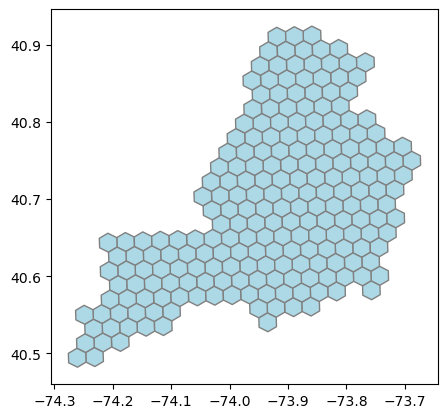

In [12]:
LatLngPoly = h3.LatLngPoly

# Load and combine NYC polygons
gdf = gpd.read_file("nyc_boroughs.geojson")
geometry = gdf.dissolve().geometry.values[0]

# Handle MultiPolygon or Polygon uniformly
polygons = geometry.geoms if geometry.geom_type == "MultiPolygon" else [geometry]

# Convert polygons to LatLngPoly for H3
latlng_polys = []
for poly in polygons:
    outer_ring = [[y, x] for x, y in poly.exterior.coords[:]]
    latlng_polys.append(h3.LatLngPoly(outer_ring))

# Collect all candidate H3 cells: base cells + neighbors
all_candidate_cells = set()
for shape in latlng_polys:
    base_cells = h3.polygon_to_cells(shape, res=7)
    candidate_cells = set(base_cells)
    for cell in base_cells:
        candidate_cells.update(h3.grid_ring(cell, 1))  # add neighbors (distance 1)
    all_candidate_cells.update(candidate_cells)

# Convert H3 cells to polygons for spatial filtering
polygons = [
    Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(cell)])
    for cell in all_candidate_cells
]

# Create GeoDataFrame of candidate hex cells
candidate_gdf = gpd.GeoDataFrame(
    {'h3_index': list(all_candidate_cells), 'geometry': polygons},
    crs='EPSG:4326'
)

# Create GeoDataFrame for original geometry
geom_gdf = gpd.GeoDataFrame({'geometry': [geometry]}, crs='EPSG:4326')

# Filter hex cells intersecting the original polygon(s)
intersecting_hexes = candidate_gdf[candidate_gdf.geometry.intersects(geometry)]

print(f"Total candidate hex cells: {len(all_candidate_cells)}")
print(f"Hex cells intersecting original polygon: {len(intersecting_hexes)}")

# Optional: Plot result
intersecting_hexes.plot(edgecolor='gray', facecolor='lightblue', figsize=(5,5))


In [13]:
# # Load and dissolve geometry
# gdf = gpd.read_file("nyc_tracts.geojson")
# geometry = gdf.dissolve().geometry.values[0]

# # Convert each polygon’s outer ring to a LatLngPoly
# polygons = geometry.geoms if geometry.geom_type == "MultiPolygon" else [geometry]

# all_cells = set()
# for poly in polygons:
#     # Convert to [lat, lng] and wrap as LatLngPoly (no holes)
#     outer_ring = [[y, x] for x, y in poly.exterior.coords[:]]
#     shape = h3.LatLngPoly(outer_ring)
#     cells = h3.polygon_to_cells(shape, res=7)
#     all_cells.update(cells)

In [14]:
def plot_df(df, column=None, ax=None):
    "Plot based on the `geometry` column of a GeoPandas dataframe"
    df = df.copy()
    df = df.to_crs(epsg=3857)  # web mercator

    if ax is None:
        _, ax = plt.subplots(figsize=(8,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    df.plot(
        ax=ax,
        alpha=0.5, edgecolor='k',
        column=column, categorical=True,
        legend=True, legend_kwds={'loc': 'upper left'},
    )
    ctx.add_basemap(ax, crs=df.crs, source=ctx.providers.CartoDB.Positron)


def plot_shape(shape, ax=None):
    df = gpd.GeoDataFrame({'geometry': [shape]}, crs='EPSG:4326')
    plot_df(df, ax=ax)


def plot_cells(cells, ax=None):
    shape = h3.cells_to_h3shape(cells)
    plot_shape(shape, ax=ax)


def plot_shape_and_cells(shape, res=7):
    fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    plot_shape(shape, ax=axs[0])
    plot_cells(h3.h3shape_to_cells(shape, res), ax=axs[1])
    fig.tight_layout()

In [15]:
# polygons = [Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(cell)]) for cell in intersecting_hexes]

# # Create GeoDataFrame
# hex_gdf = gpd.GeoDataFrame({'h3_index': list(intersecting_hexes), 'geometry': polygons}, crs='EPSG:4326')

# # Plotting
# fig, ax = plt.subplots(figsize=(7, 7))
# hex_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=0.5)
# gpd.read_file("nyc_boroughs.geojson").dissolve().boundary.plot(ax=ax, color='red', linewidth=1)

# ax.axis('off')
# plt.show()

In [16]:
# Convert each H3 cell index in intersecting_hexes to a Shapely Polygon
polygons = [
    Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(cell)])
    for cell in intersecting_hexes['h3_index']
]

# Create GeoDataFrame with same CRS
hex_gdf = gpd.GeoDataFrame(
    {'h3_index': intersecting_hexes['h3_index'], 'geometry': polygons},
    crs='EPSG:4326'
)

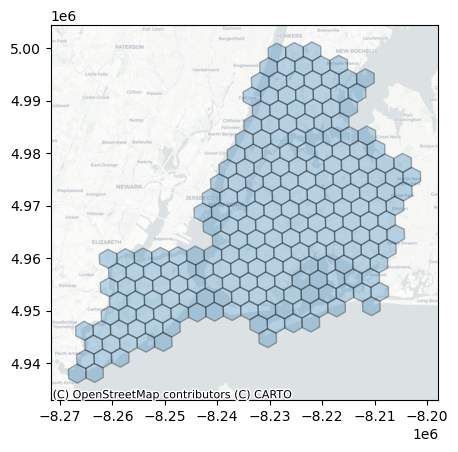

In [17]:
hex_gdf_proj = hex_gdf.to_crs(epsg=3857)

# Plot with background
ax = hex_gdf_proj.plot(figsize=(5, 5), alpha=0.3, edgecolor='black')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,
                alpha=0.8, crs=hex_gdf_proj.crs)
# plt.show()

In [18]:
hex_gdf.head()

,h3_index,geometry
0,872a100c6ffffff,"POLYGON ((-73.89823 40.75666, -73.91297 40.750..."
2,872a100c8ffffff,"POLYGON ((-73.86559 40.68352, -73.88031 40.676..."
4,872a10762ffffff,"POLYGON ((-73.95383 40.64422, -73.96853 40.637..."
5,872a10769ffffff,"POLYGON ((-73.89136 40.57199, -73.90604 40.565..."
6,872a100f5ffffff,"POLYGON ((-73.86966 40.79443, -73.88441 40.787..."


# **GET POPULATION AND CENSUS DATA**

In [19]:
# --- Step 1: Load data ---
# Load census tracts shapefile
gdf = gpd.read_file("nyc_census/tl_2023_36_tract.shp")

# Load ACS data
df = pd.read_csv("nyc_census/ACSDT5Y2023.B01003-Data.csv", skiprows=1)
df["GEOID"] = df["Geography"].str.extract(r'(\d{11})')
df = df.rename(columns={"Estimate!!Total": "population"})

# Merge on GEOID
merged = gdf.merge(df[["GEOID", "population"]], on="GEOID", how="left")

# Drop missing geometries and populations
merged = merged[merged.geometry.notnull() & merged.population.notnull()]


In [20]:
# --- Step 2: Load NYC boroughs and filter ---
nyc_boroughs = gpd.read_file("nyc_boroughs.geojson")
nyc_boroughs = nyc_boroughs.to_crs(merged.crs)

# Filter tracts that intersect NYC boroughs
merged = merged[merged.intersects(nyc_boroughs.unary_union)].copy()

# --- Step 3: Calculate centroids ---
merged["centroid"] = merged.geometry.centroid
merged["lon"] = merged.centroid.x
merged["lat"] = merged.centroid.y

# --- Step 4: Remove mostly-water tracts ---
# Calculate tract area and intersection area
merged["tract_area"] = merged.geometry.area
intersection = gpd.overlay(merged, nyc_boroughs, how="intersection")
intersection["intersection_area"] = intersection.geometry.area

# Calculate percent overlap with borough land
area_df = intersection.groupby("GEOID")["intersection_area"].sum().reset_index()
merged = merged.merge(area_df, on="GEOID", how="left")
merged["percent_overlap"] = merged["intersection_area"] / merged["tract_area"]

# Keep only tracts with at least 5% overlap
tracts_filtered = merged[merged["percent_overlap"] > 0.05].copy()

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_40648/1720800781.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged = merged[merged.intersects(nyc_boroughs.unary_union)].copy()
/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_40648/1720800781.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged["centroid"] = merged.geometry.centroid
/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_40648/1720800781.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged["lon"] = merged.centroid.x
/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_40648/1720800781.py:11: UserWarning: Geometry is in a geographic CRS.

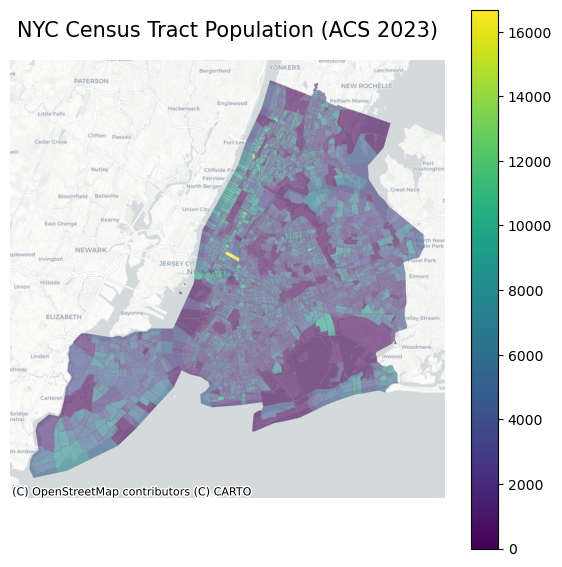

In [21]:
# --- Step 5: Plot with base map ---
tracts_filtered = tracts_filtered.to_crs(epsg=3857)  # Web Mercator for basemap
fig, ax = plt.subplots(figsize=(7, 7))
tracts_filtered.plot(
    column="population",
    cmap="viridis",
    linewidth=0.3,
    alpha=0.6,
    edgecolor="gray",
    legend=True,
    ax=ax
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("NYC Census Tract Population (ACS 2023)", fontsize=15)
ax.axis("off")
plt.show()

In [22]:
# Project to a CRS suitable for centroid computation
tracts_projected = tracts_filtered.to_crs(epsg=2263)  # NY State Plane East

# Compute centroids
tracts_projected["centroid_geom"] = tracts_projected.geometry.centroid

# Reproject back to WGS84 (if needed)
tracts_projected = tracts_projected.to_crs(epsg=4326)
tracts_projected["centroid_geom"] = tracts_projected["centroid_geom"].to_crs(epsg=4326)

# Select relevant columns
population_gdf = tracts_projected[["GEOID", "population", "geometry", "centroid_geom"]].copy()

# Rename for clarity
population_gdf = population_gdf.rename(columns={"geometry": "tract_geometry", "centroid_geom": "tract_centroid"})

population_gdf.head()


,GEOID,population,tract_geometry,tract_centroid
0,36081003400,2600.0,"POLYGON ((-73.8663 40.68319, -73.86549 40.6834...",POINT (-73.85819 40.68477)
1,36081003900,1474.0,"POLYGON ((-73.9433 40.76066, -73.94247 40.7619...",POINT (-73.94093 40.7628)
2,36081003600,3448.0,"POLYGON ((-73.8641 40.68237, -73.8637 40.68248...",POINT (-73.85682 40.68377)
3,36081003700,0.0,"POLYGON ((-73.95077 40.75531, -73.95073 40.755...",POINT (-73.94334 40.76242)
4,36081003800,2255.0,"POLYGON ((-73.8528 40.68425, -73.85196 40.6844...",POINT (-73.84749 40.6848)


# **COMBINE INTO ONE GDF**

In [45]:
hex_gdf_proj.head()

,h3_index,geometry,grocery,restaurant,warehouse,count
0,872a100c6ffffff,"POLYGON ((-8226313.819 4976515.373, -8227954.1...",21,145,0,21
1,872a100c8ffffff,"POLYGON ((-8222679.853 4965772.937, -8224318.1...",3,7,0,3
2,872a10762ffffff,"POLYGON ((-8232502.899 4960005.023, -8234138.5...",6,20,1,6
3,872a10769ffffff,"POLYGON ((-8225548.562 4949413.704, -8227182.5...",0,0,1,0
4,872a100f5ffffff,"POLYGON ((-8223132.584 4982067.412, -8224774.6...",0,16,0,0


In [23]:
# Convert POIs to GeoDataFrame in WGS84
gdf_pois = gpd.GeoDataFrame(
    poi_df,
    geometry=gpd.points_from_xy(poi_df.lon, poi_df.lat),
    crs="EPSG:4326"
)

# Reproject POIs to EPSG:3857 to match hex_gdf_proj
gdf_pois_proj = gdf_pois.to_crs(epsg=3857)

# Spatial join: find which POIs fall within each hex polygon
joined = gpd.sjoin(
    gdf_pois_proj,
    hex_gdf_proj[['h3_index', 'geometry']],
    how='inner',
    predicate='within'
)

# Count POIs per hex and type
counts = joined.groupby(['h3_index', 'type']).size().reset_index(name='count')

# Pivot to get one column per POI type with counts
counts_pivot = counts.pivot(index='h3_index', columns='type', values='count').fillna(0).reset_index()

# Merge counts back to hex_gdf_proj
hex_gdf_with_counts = hex_gdf_proj.merge(counts_pivot, on='h3_index', how='left').fillna(0)

# Convert counts to int (optional)
for col in counts['type'].unique():
    hex_gdf_with_counts[col] = hex_gdf_with_counts[col].astype(int)

hex_gdf_with_counts.head()

,h3_index,geometry,grocery,restaurant,warehouse
0,872a100c6ffffff,"POLYGON ((-8226313.819 4976515.373, -8227954.1...",21,145,0
1,872a100c8ffffff,"POLYGON ((-8222679.853 4965772.937, -8224318.1...",3,7,0
2,872a10762ffffff,"POLYGON ((-8232502.899 4960005.023, -8234138.5...",6,20,1
3,872a10769ffffff,"POLYGON ((-8225548.562 4949413.704, -8227182.5...",0,0,1
4,872a100f5ffffff,"POLYGON ((-8223132.584 4982067.412, -8224774.6...",0,16,0


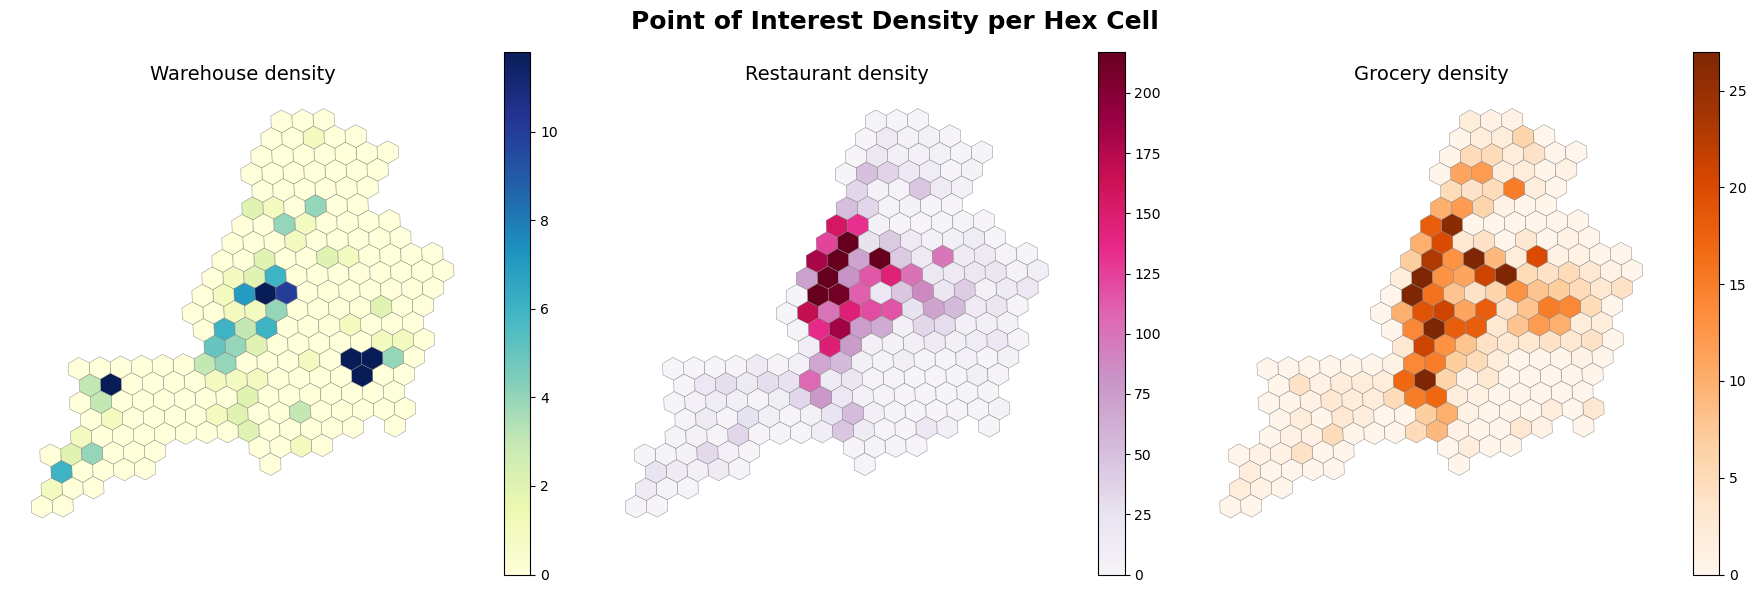

In [24]:
poi_types = ['warehouse', 'restaurant', 'grocery']
color_maps = {
    'warehouse': 'YlGnBu',
    'restaurant': 'PuRd',
    'grocery': 'Oranges'
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

for ax, poi_type in zip(axes, poi_types):
    if poi_type in hex_gdf_with_counts.columns:
        vmax = np.percentile(hex_gdf_with_counts[poi_type], 98)
        hex_gdf_with_counts['count'] = hex_gdf_with_counts[poi_type]
    else:
        vmax = 1
        hex_gdf_with_counts['count'] = 0

    hex_gdf_with_counts.plot(
        column='count',
        ax=ax,
        legend=True,
        cmap=color_maps[poi_type],
        edgecolor='gray',
        linewidth=0.3,
        vmax=vmax,
        missing_kwds={"color": "#f0f0f0"},
    )
    ax.set_title(f'{poi_type.capitalize()} density', fontsize=14)
    ax.axis('off')

plt.suptitle("Point of Interest Density per Hex Cell", fontsize=18, weight='bold')
plt.tight_layout()
plt.show()

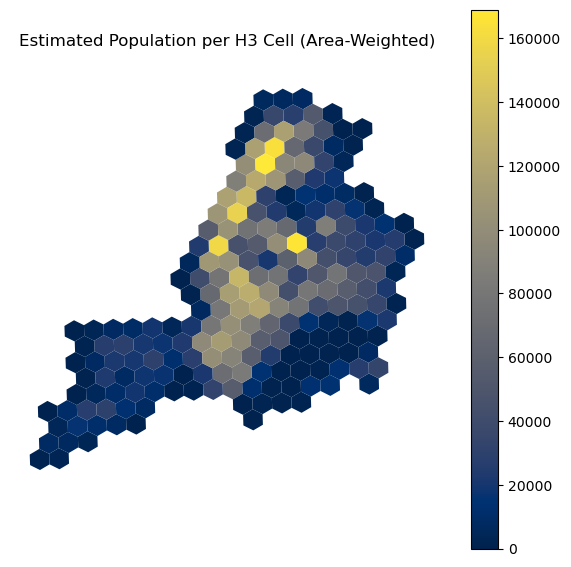

In [68]:
# Estimate population per hex cell using area-weighted interpolation approach

# Project CRS to metric for area calcs
hex_gdf_proj = hex_gdf_with_counts.to_crs(epsg=3857)
tracts_proj = population_gdf.copy()
tracts_proj = tracts_proj.set_geometry('tract_geometry').to_crs(epsg=3857)
tracts_proj['tract_area'] = tracts_proj.geometry.area

# Overlay intersection (tracts x hex)
intersections = gpd.overlay(tracts_proj, hex_gdf_proj, how='intersection')

# Calculate intersection area
intersections['intersection_area'] = intersections.geometry.area

# Calculate estimated population by proportion of area
intersections['pop_est'] = intersections['population'] * (
    intersections['intersection_area'] / intersections['tract_area']
)

# Aggregate population estimates by hex
hex_population = intersections.groupby('h3_index')['pop_est'].sum().reset_index()

# Merge into hex grid
hex_gdf_with_pop = hex_gdf_with_counts.merge(hex_population, on='h3_index', how='left')
hex_gdf_with_pop['pop_est'] = hex_gdf_with_pop['pop_est'].fillna(0)

# Plot result
hex_gdf_with_pop.to_crs(epsg=3857).plot(
    column='pop_est',
    cmap='cividis',
    legend=True,
    figsize=(7, 7),
    edgecolor='none'
)
plt.title("Estimated Population per H3 Cell (Area-Weighted)")
plt.axis('off')
plt.show()


In [69]:
hex_gdf_with_pop.head()

,h3_index,geometry,grocery,restaurant,warehouse,count,pop_est
0,872a100c6ffffff,"POLYGON ((-8226313.819 4976515.373, -8227954.1...",21,145,0,21,101202.859581
1,872a100c8ffffff,"POLYGON ((-8222679.853 4965772.937, -8224318.1...",3,7,0,3,76926.522879
2,872a10762ffffff,"POLYGON ((-8232502.899 4960005.023, -8234138.5...",6,20,1,6,97605.388775
3,872a10769ffffff,"POLYGON ((-8225548.562 4949413.704, -8227182.5...",0,0,1,0,957.863592
4,872a100f5ffffff,"POLYGON ((-8223132.584 4982067.412, -8224774.6...",0,16,0,0,4678.023328
